In [5]:
#   Mount Google Drive

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#Copy kaggle.json to the Right Location

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [19]:
# Download the Chest X-ray dataset from Kaggle

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d /content/chest_xray



Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace /content/chest_xray/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/chest_xray/chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
#  Import Libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [34]:
# Set Dataset Paths

base_dir = '/content/chest_xray/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [35]:
# Data Preprocessing & Augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [36]:
# Explanation: We create data loaders for train/val/test splits with a batch size of 32 and resize images to 150x150.
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [37]:
# Build the CNN Model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# Explanation:
# We compile the model with:

# adam optimizer for adaptive learning

# binary_crossentropy loss for binary classification

# Accuracy as the evaluation metric

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
#Train the Model

# Explanation: We train the model for 10 epochs and validate after each epoch using the validation set.


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 424ms/step - accuracy: 0.7005 - loss: 0.7039 - val_accuracy: 0.5000 - val_loss: 0.6415
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 419ms/step - accuracy: 0.7814 - loss: 0.3604 - val_accuracy: 0.6250 - val_loss: 0.7900
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.8795 - loss: 0.3015 - val_accuracy: 0.8750 - val_loss: 0.4469
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - accuracy: 0.8950 - loss: 0.2720 - val_accuracy: 0.7500 - val_loss: 0.6724
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 424ms/step - accuracy: 0.9009 - loss: 0.2587 - val_accuracy: 0.6875 - val_loss: 0.9028
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.9192 - loss: 0.2194 - val_accuracy: 0.6250 - val_loss: 0.9423
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.9249 - loss: 0.2168 - val_accuracy: 0.6875 - val_loss: 0.9230
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.9283 - loss: 0

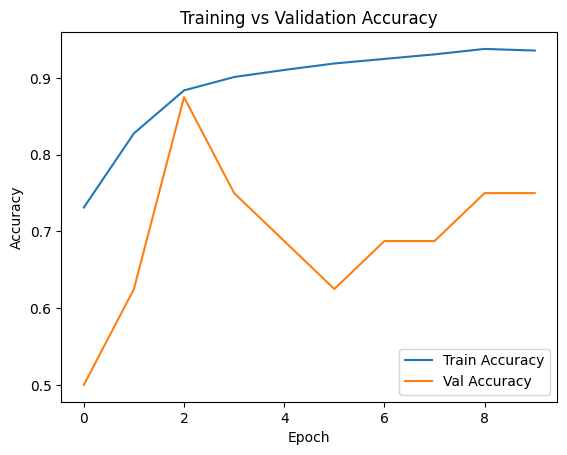

In [40]:
# Visualize Training Progress
# Explanation: Visualizing accuracy trends helps detect overfitting or underfitting.

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [41]:
# Evaluate Model on Test Data
# Explanation: We evaluate final performance on unseen test data

test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.8517 - loss: 0.5366
✅ Test Accuracy: 0.90


In [42]:
# Confusion Matrix & Classification Report
#Explanation: Predict binary classes (0: Normal, 1: Pneumonia)

predictions = (model.predict(test_generator) > 0.5).astype("int32")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step


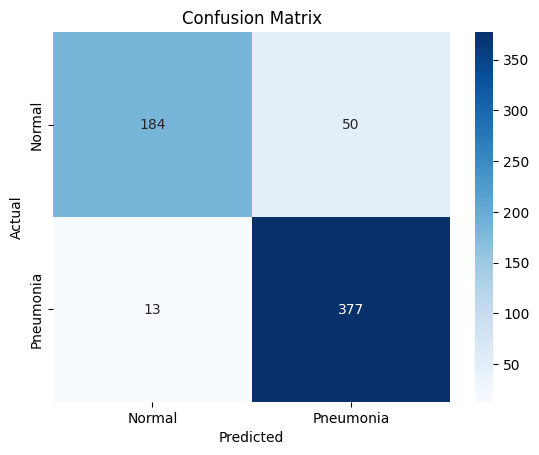

In [43]:
# Explanation: Confusion matrix shows true vs predicted labels to evaluate precision and recall

cm = confusion_matrix(test_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [44]:
# Explanation: This gives detailed performance metrics — precision, recall, f1-score for each class

print(classification_report(test_generator.classes, predictions, target_names=['Normal', 'Pneumonia']))


              precision    recall  f1-score   support

      Normal       0.93      0.79      0.85       234
   Pneumonia       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



In [45]:
# Save the Trained Model
# Explanation: Save the trained model for later use or deployment in an app (e.g., Streamlit or Flask).


model.save("pneumonia_cnn_model.h5")
print("✅ Model saved as 'pneumonia_cnn_model.h5'")


✅ Model saved as 'pneumonia_cnn_model.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


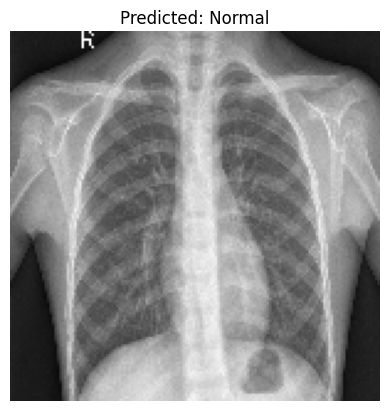

In [51]:
from tensorflow.keras.preprocessing import image

img_path = test_generator.filepaths[0]
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img) / 255.
img_tensor = np.expand_dims(img_tensor, axis=0)

prediction = model.predict(img_tensor)
label = 'Pneumonia' if prediction > 0.5 else 'Normal'

plt.imshow(img)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()
